# Surface tracer fields

Fig. 2 from Moore-Maley and Allen, 2021, Ocean Sci.:

MODIS surface temperature observations from the NASA Aqua satellite, and SalishSeaCast surface temperature and nitrate during four cloud-free upwelling events.

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
from cartopy import crs, feature

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

Load paths, initialize datasets and define event dates and MODIS swath bounding boxes

Cloud-free swaths were originally identified using the [NASA Ocean Color level 1 & 2 browser](https://oceancolor.gsfc.nasa.gov/cgi/browse.pl?sen=amod).

In [3]:
# NASA PO.DAAC OPeNDAP server url and filename
url_MODIS = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/MODIS_A/JPL/v2019.0/'
fn_MODIS = 'JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc'

# NEMO grid reference data
url_SSC = 'https://salishsea.eos.ubc.ca/erddap/griddap/'
SSC = {'grid': xr.open_dataset(f'{url_SSC}ubcSSnBathymetryV17-02')}
for file, var in zip(['Tracer', 'Biology'], ['temperature', 'nitrate']):
    SSC[var] = xr.open_dataset(f'{url_SSC}ubcSSg3D{file}Fields1hV19-05')[var].isel(depth=0)

# Initialize data dict
data = {'MODIS': {}, 'SSC': {var: SSC['grid'][var].values for var in ('longitude', 'latitude')}}

# Upwelling events
events = [
    {'date': '04 Sep 2015 21:40:00', 'bbox': (slice(  70,  310), slice( 200,  350))},
    {'date': '30 Jul 2016 20:35:10', 'bbox': (slice(1470, 1750), slice(1100, 1220))},
    {'date': '12 Sep 2018 21:40:01', 'bbox': (slice( 210,  500), slice( 200,  350))},
    {'date': '20 Jun 2019 21:30:00', 'bbox': (slice(1650, 1900), slice( 270,  430))},
]

***

Load individual swaths and plot surface fields

/home/bmoorema/miniconda3/envs/SoG_upwelling_EOF_paper/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/bmoorema/miniconda3/envs/SoG_upwelling_EOF_paper/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/bmoorema/miniconda3/envs/SoG_upwelling_EOF_paper/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.


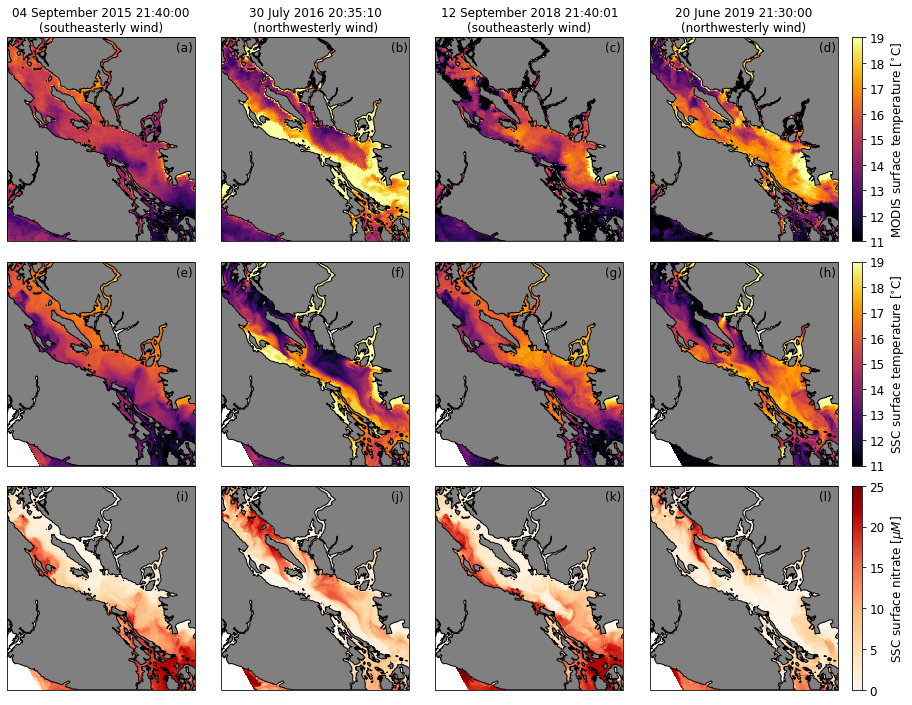

In [5]:
# Initialize plot
xlim, ylim, got_cbar = [-125.2, -122.8], [48.5, 50.2], False
subplot_kw, gridspec_kw = {'projection': crs.Mercator(np.mean(xlim), *ylim)}, {'hspace': 0.1, 'wspace': 0.1}
fig, axs = plt.subplots(3, 4, figsize=(15, 12), subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)

# Loop through upwelling events
for col, event in zip(axs.T, events):
    
    # Parse date
    date = parse(event['date'])

    # Load MODIS from PO.DAAC OPeNDAP server
    year, yearday, timestamp = date.year, datetime.timetuple(date).tm_yday, date.strftime('%Y%m%d%H%M%S')
    fn = f'{url_MODIS}/{year}/{yearday}/{timestamp}-{fn_MODIS}'
    with xr.open_dataset(fn) as ds:
        data['MODIS']['longitude'] = ds['lon'].values[event['bbox']]
        data['MODIS']['latitude'] = ds['lat'].values[event['bbox']]
        data['MODIS']['temperature'] = ds.sea_surface_temperature[0, ...].values[event['bbox']] - 273.15
    
    # Load SSC
    for var in ['temperature', 'nitrate']:
        data['SSC'][var] = SSC[var].sel(time=date, method='nearest').values
        
    # Plot each variable
    for ax, key, var in zip(col, ['MODIS', 'SSC', 'SSC'], ['temperature', 'temperature', 'nitrate']):
        
        # Variable attributes
        if var == 'temperature':
            cmap, clim, units = 'inferno', [11, 19], '$^{\circ}$C'
        else:
            cmap, clim, units = 'OrRd', [0, 25], '$\mu M$'
        
        # Format map and plot surface fields
        ax.set_extent(xlim + ylim)
        ax.add_feature(feature.GSHHSFeature('h', edgecolor='k', facecolor='gray'))
        c = ax.pcolormesh(
            data[key]['longitude'], data[key]['latitude'], data[key][var], vmin=clim[0], vmax=clim[1],
            cmap=cmap, transform=crs.PlateCarree(), rasterized=True,
        )
        
        # Add colorbar
        if not got_cbar:
            pos = ax.get_position()
            cax = fig.add_axes([0.91, pos.y0, 0.01, pos.height])
            fig.colorbar(c, cax=cax, label=f'{key} surface {var} [{units}]')
    
    # Add title
    wdir = 'southeasterly' if date.month == 9 else 'northwesterly'
    col[0].set_title(f"{date.strftime('%d %B %Y %H:%M:%S')}\n({wdir} wind)", fontsize=12)
    got_cbar = True

# Add panel labels
for ax, k in zip(axs.ravel(), range(12)):
    ax.text(0.9, 0.93, f'({chr(97+k)})', transform=ax.transAxes)